In [1]:
import sys
from importlib import reload
from functools import partial
import time

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from utils_trifluxonium import DeviceParams, SimulParams
from utils_trifluxonium import get_phiext_grid
from utils_trifluxonium_solve import H_triflux_phaselike, diagonalise, get_ekets_3D, g_calc, write2vtk
from utils_trifluxonium_visual import plot_eigenstates, potential, plot_potential

In [3]:
reload(sys.modules['utils_trifluxonium'])
reload(sys.modules['utils_trifluxonium_solve'])

<module 'utils_trifluxonium_solve' from '/Users/shiyesu/Documents/trifluxonium/utils_trifluxonium_solve.py'>

In [4]:
savefig = False

In [5]:
# ball park ranges:  EC 0.2-2, EJ 8-100, EL 0.3-3
device = DeviceParams(
    EC=None, 
    EJ=None,
    EL=None,
)

device

DeviceParams(EC=2, EJ=15, EL=0.3)

In [6]:
simul = SimulParams(
    tol=None,
    keig=None,
    N_zeta=None,
    N_theta=None,
    N_chi=None,
    D_zeta=None,
    D_theta=None,
    D_chi=None,
)

simul

SimulParams(tol=1e-10, keig=10, N_zeta=100, N_theta=101, N_chi=101, D_zeta=3.141592653589793, D_theta=12.566370614359172, D_chi=12.566370614359172)

# Diagonalise

In [7]:
print(f"{device=}")

phiext = 0 # decoupled

# hamiltonian of dimension N_zeta * N_theta * N_chi
hamiltonian = H_triflux_phaselike(
    phiext, 
    device.EJ, 
    device.EC, 
    device.EL,
    simul.N_zeta,
    simul.N_theta,
    simul.N_chi,
    simul.D_zeta,
    simul.D_theta,
    simul.D_chi
)

start = time.time()
evals, ekets = diagonalise(operator=hamiltonian,
                           keig=simul.keig,
                           ground_guess=np.random.rand(hamiltonian.shape[0]),
                           tol=simul.tol,
                          )
end = time.time()
elapsed_time = end - start
print("elapsed time: {}".format(elapsed_time))

device=DeviceParams(EC=2, EJ=15, EL=0.3)
elapsed time: 26.698474884033203


In [8]:
ekets_3D = get_ekets_3D(ekets, simul)
print(f"{ekets_3D.shape=}")

ekets_3D.shape=(100, 101, 101, 10)


# Eigenenergies

evals=array([ 0.        , 10.88050089, 10.90013668, 10.90032085, 10.95358028,
       10.95396294, 10.97020152, 13.16413679, 13.61839582, 13.61885493])


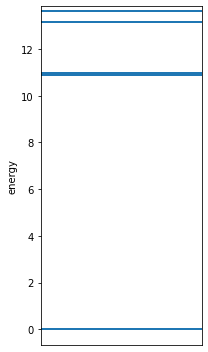

In [9]:
print(f"{evals=}")

plt.figure(figsize=(3,5))
for i in range(simul.keig):
    plt.axhline(evals[i], linewidth=2.0, linestyle='-')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False)
# plt.ylim([0, 15])
plt.ylabel("energy")

plt.tight_layout()
plt.show()

if savefig: plt.savefig("energy.pdf")

# Coupling

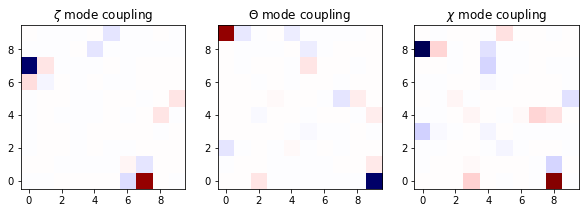

In [10]:
g_mat = g_calc(evals, ekets, simul)

from matplotlib.colors import SymLogNorm

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(g_mat[0,:,:], cmap='seismic', origin='lower', vmin=-0.7, vmax=0.7)
plt.title('$\zeta$ mode coupling')
plt.subplot(1,3,2)
plt.imshow(g_mat[1,:,:], cmap='seismic',origin='lower', vmin=-0.7,vmax=0.7)
plt.title('$\Theta$ mode coupling')
plt.subplot(1,3,3)
plt.imshow(g_mat[2,:,:], cmap='seismic', origin='lower', norm=SymLogNorm(linthresh=0.3, vmin=-0.7, vmax=0.7))
# plt.colorbar()
plt.title('$\chi$ mode coupling')
plt.show()

if savefig: plt.savefig("coupling.pdf")

# Eigenstates

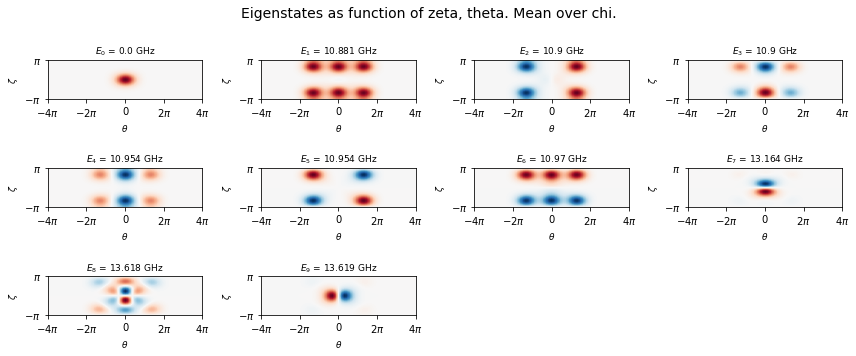

In [11]:
plot_eigenstates(evals, ekets_3D, simul, dim_trace_over=2);

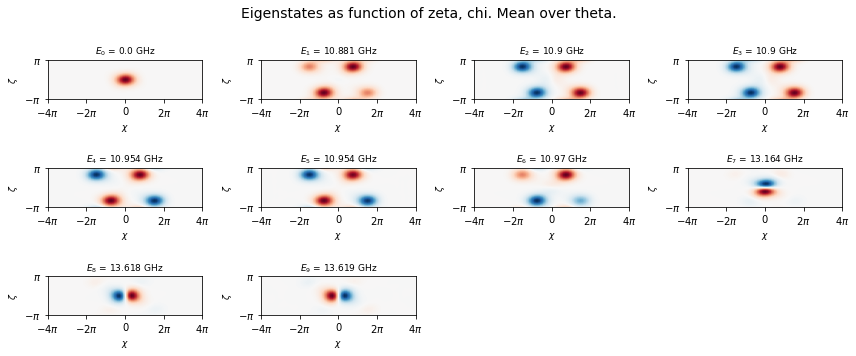

In [12]:
plot_eigenstates(evals, ekets_3D, simul, dim_trace_over=1);

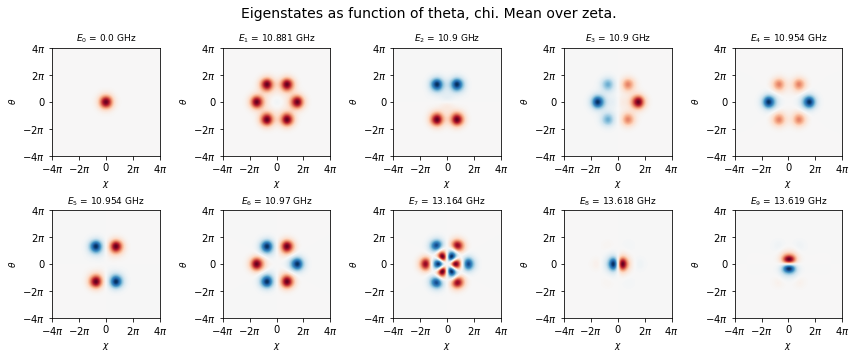

In [13]:
plot_eigenstates(evals, ekets_3D, simul, dim_trace_over=0);

# Potential visualisation

In [14]:
V_3D = potential(device, simul)

Computing potential for trifluxonium given by DeviceParams(EC=2, EJ=15, EL=0.3).


## Slice along zeta

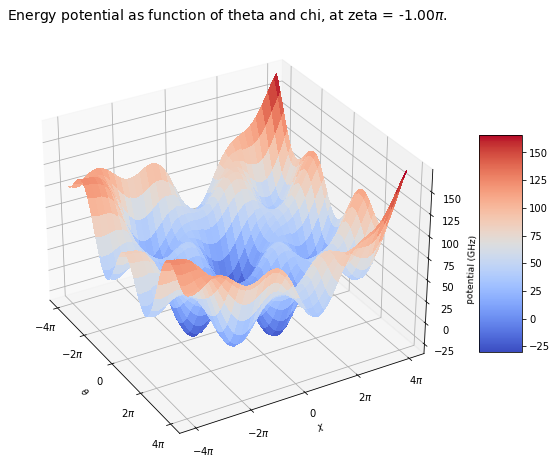

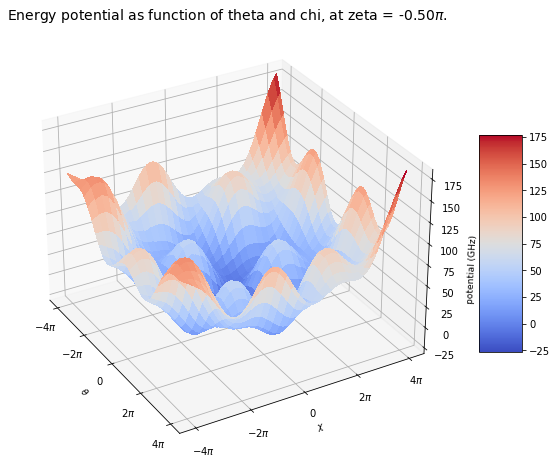

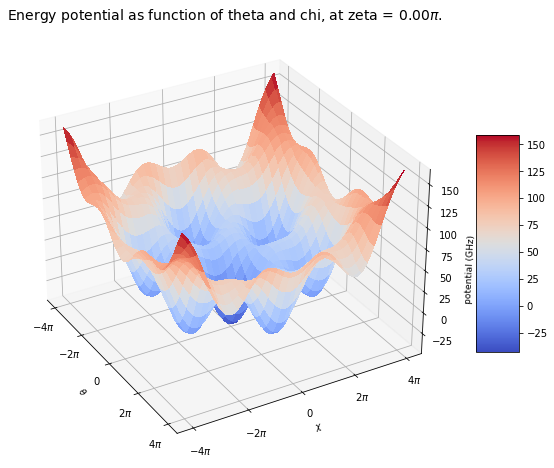

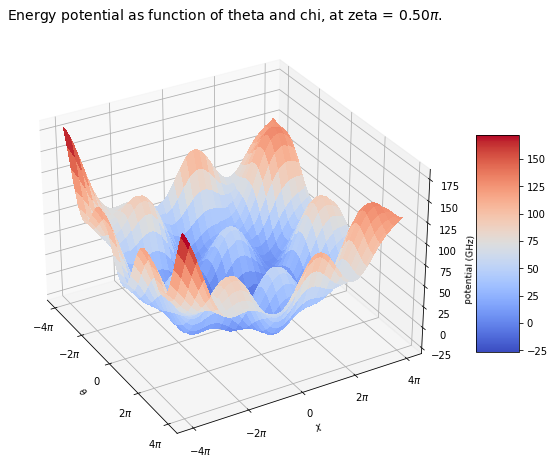

In [15]:
for index_to_slice in range(0, simul.N_zeta, 25):
    plot_potential(index_to_slice=index_to_slice, dim_to_slice=0, V_3D=V_3D, simul=simul, show_colorbar=True);

## Slice along theta

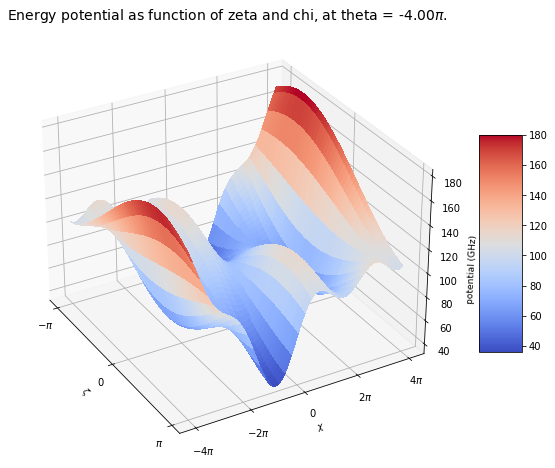

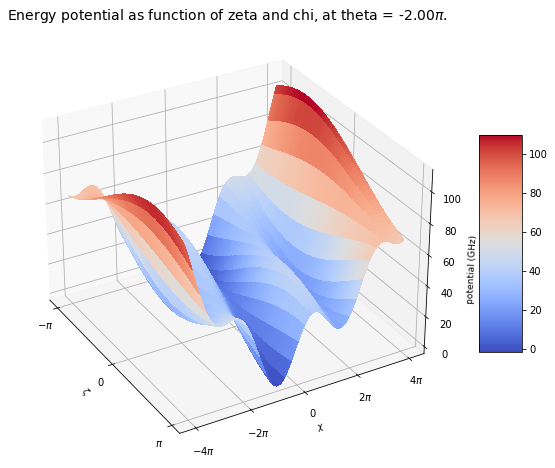

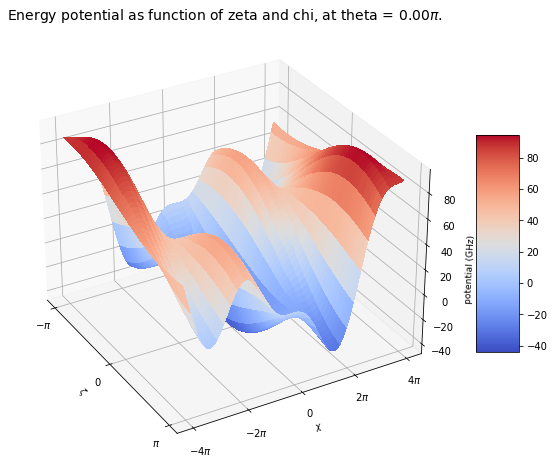

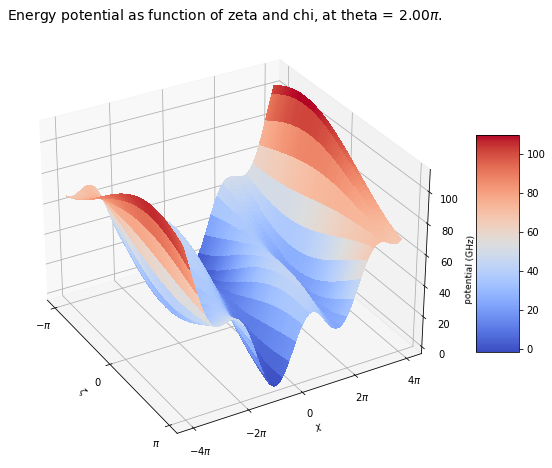

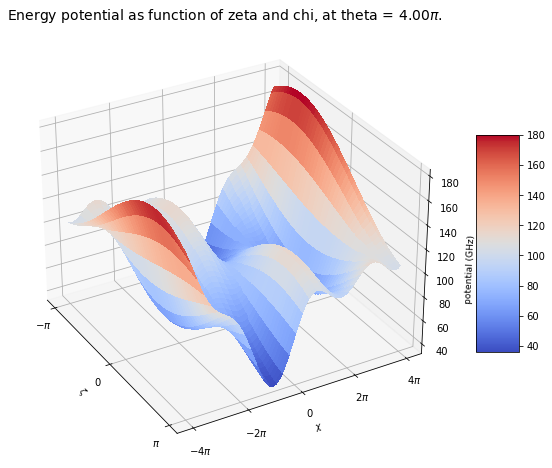

In [16]:
for index_to_slice in range(0, simul.N_theta, 25):
    plot_potential(index_to_slice=index_to_slice, dim_to_slice=1, V_3D=V_3D, simul=simul, show_colorbar=True);

## Slice along chi

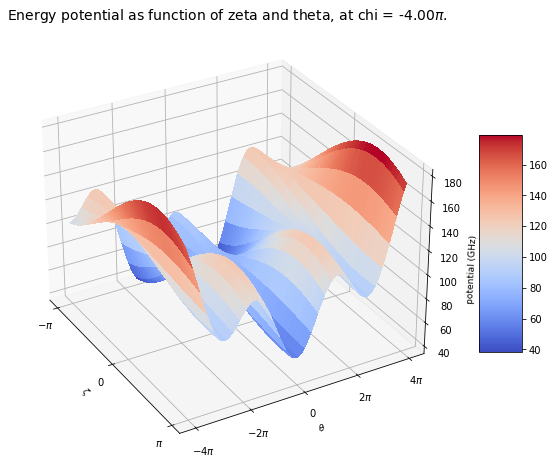

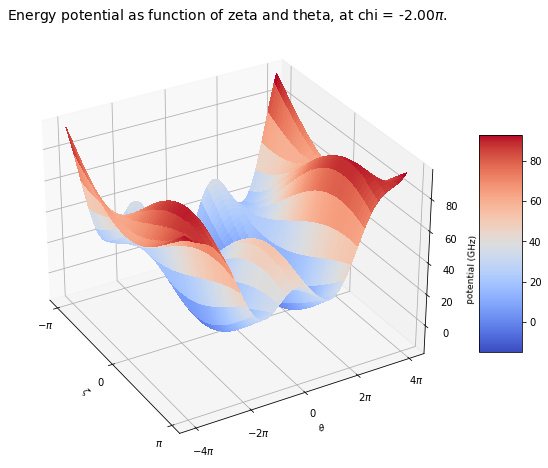

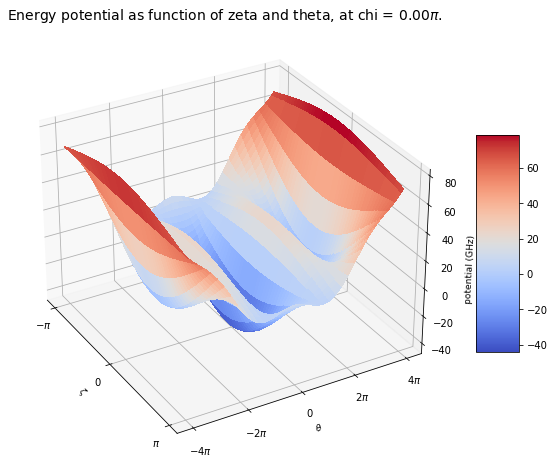

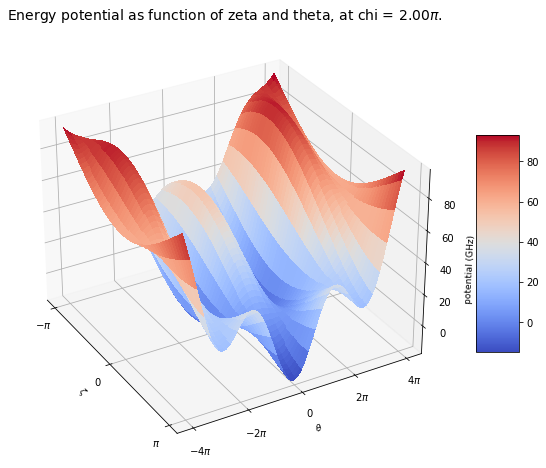

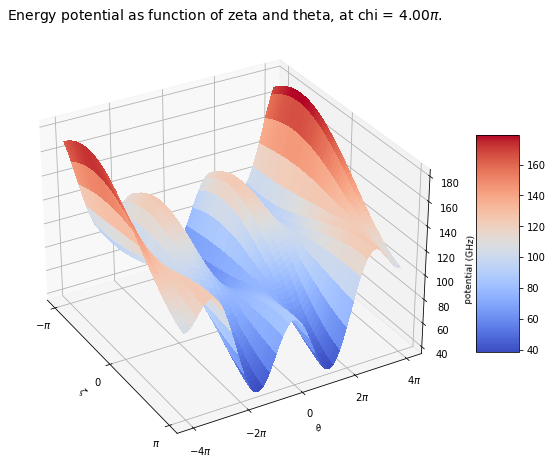

In [17]:
for index_to_slice in range(0, simul.N_chi, 25):
    plot_potential(index_to_slice=index_to_slice, dim_to_slice=2, V_3D=V_3D, simul=simul, show_colorbar=True);

# Save vtk

In [102]:
for i in range(simul.keig):
    write2vtk(ekets_3D[:,:,:,i], fname="ekets" + str(i) + ".vtk")
write2vtk(V_3D, fname="potential.vtk")

# Fluxonium single deg freedom potential

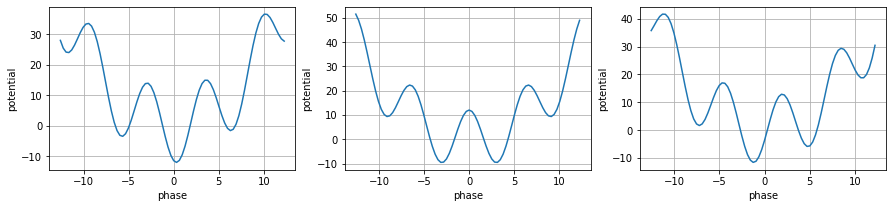

In [18]:
phiext = np.array([0.05, 0.5, 0.8]) * 2 * np.pi
ej = 12
el = 0.5

phase = np.arange(-4*np.pi, 4*np.pi, np.pi / 10)

plt.figure(figsize=(15,3))
for i in range(phiext.size):
    pot = -ej * np.cos(phase - phiext[i]) + 0.5 * el * phase**2
    plt.subplot(1,3,i+1)
    plt.plot(phase, pot)
    plt.grid()
    plt.xlabel("phase")
    plt.ylabel("potential")